In [15]:
import _plot_functions
import _functions
import matplotlib.pyplot as plt
import periodictable as pt
from periodictable import constants
import numpy as np
import pandas as pd
%matplotlib inline

Parsed chemical formula: {'Ag': 1, 'Au': 1, 'W': 1, 'Hf': 1, 'Cd': 1, 'Co': 1, 'In': 1}
Thickness (cm):  {'Ag': 0.01, 'Au': 0.01, 'W': 0.01, 'Hf': 0.01, 'Cd': 0.01, 'Co': 0.01, 'In': 0.01}


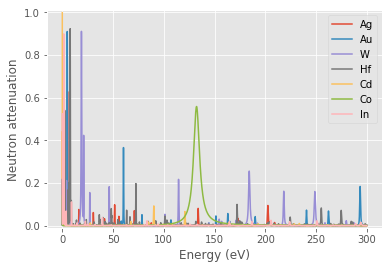

In [16]:
# Parameters
# _input_formula = elements_str
_input_formula = 'AgAuWHfCdCoCdIn'  # input('Please input the chemicals? ')
_input_thick_mm = 0.1  # float(input('Please input the thickness in mm : '))
_input_thick_cm = _input_thick_mm/10
_database = 'ENDF_VIII'
energy_max = 300  # max incident energy in eV
energy_min = 0  # min incident energy in eV
energy_sub = 100
sub_x = energy_sub * (energy_max - energy_min)  # subdivided new x-axis
_plot_or_not = 'Y'
_energy_x_axis = 'Y'  # 1 means plot x-axis as energy in eV
_trans_y_axis = 'N'  # 1 means plot y-axis as transmission
_plot_each_ele_contribution = 'Y'  # 1 means plot each element's contribution
_plot_each_iso_contribution = 'N'  # 1 means plot each isotope's contribution
_plot_mixed = 'N'  # 1 means plot mixed resonance


formula_dict = _functions.input2formula(_input_formula)  # Function called to parse input formula and return elements and ratios
elements = _functions.dict_key_list(formula_dict)
ratios = _functions.dict_value_list(formula_dict)
all_ele_boo_dict = _functions.boo_dict(elements, 'Y')  # Y/N Dict for natural mixture
thick_boo_dict = _functions.boo_dict(elements, 'Y')  # Y/N Dict for same thickness
thick_cm_dict = _functions.thick_dict(elements, _input_thick_cm)
density_boo_dict = _functions.boo_dict(elements, 'N')  # Y/N Dict for density manual input
density_gcm3_dict = _functions.density_dict(elements)

### For element with various thickness:
_thick_input = 'N'  # input('Is there any element with different thickness? ')
if _thick_input == 'Y':
    resize_element_str = input('Please list all separated by only " ": ')
    resize_element = resize_element_str.split(' ')
    density_element = _functions.boo_dict_invert_by_key(resize_element, thick_boo_dict)
    for ele in resize_element:
        thick_cm_dict[ele] = float(input('Thickness of {} in mm: '.format(ele)))
print('Thickness (cm): ', thick_cm_dict)


### For sample doesn't have standard density:
_density_input = 'N' #input('Mixture or any element not follow standard density? ')
if _density_input == 'Y':
    _diff_density_pure = input('Pure element but would like to input density other than standard? ')
    if _diff_density_pure == 'Y':
        _compound = 'N'
        density_element_str = input('Please list all separated by only " ": ')
        density_element = density_element_str.split(' ')
        density_boo_dict = _functions.boo_dict_invert_by_key(density_element, density_boo_dict)
        for ele in density_element:
            density_gcm3_dict[ele] = float(input('Modified density of {} in g/cm3: '.format(ele)))
    else:
        _compound = 'Y'
    print('Density (g/cm3): ', density_gcm3_dict)


### For element doesn't contain isotopes in natural abundance:
_unnatural_ele_input = 'N' #input('Is there any unnatural mixture? ')
if _unnatural_ele_input == 'Y':
    unnatural_ratio_dicts = {}
    unnatural_element_str = input('Please list all separated by only " ": ')
    unnatural_element = unnatural_element_str.split(' ')
    all_ele_boo_dict = _functions.boo_dict_invert_by_key(unnatural_element, all_ele_boo_dict)
    isotope_dict = _functions.get_isotope_dict(_database, unnatural_element)
    print(isotope_dict)
    for ele in unnatural_element:
        isotopes = isotope_dict[ele]
        unnatural_ratio_dict = {}
        iso_density_dict = {}
        for iso in isotopes:
            unnatural_ratio_dict[iso] = float(input('Atomic ratio of {} in mixture: '.format(iso)))
            iso_density_dict[iso] = pt.elements.isotope(iso).density
        # Get array of isotopic density
        iso_density_list = list(dict.values(iso_density_dict))
        iso_density_array = np.array(iso_density_list)
        # Get array of input/modified isotopic atomic ratio
        iso_unnatural_ratio_list = list(dict.values(unnatural_ratio_dict))
        iso_unnatural_ratio_array = np.array(iso_unnatural_ratio_list)
        # Calculate the modified density due to the introduced change in isotopic abundance
        ratio_modified_density = sum(iso_unnatural_ratio_array * iso_density_array)
        unnatural_ratio_dicts[ele] = unnatural_ratio_dict
        density_gcm3_dict[ele] = ratio_modified_density
    # print(unnatural_ratio_dicts)
    # print(density_gcm3_dicts)
    # print(density_gcm3_dict)


mass_iso_ele_dict = {}  # For number of atoms per cm3 calculation
sigma_iso_ele_eleisodict = {}  # For transmission calculation at isotope lever
sigma_iso_ele_sum_eledict = {}  # For transmission calculation at element lever
sigma_iso_ele_sum_l_eledict = {}
sigma_iso_ele_l_eleisodict = {}
df_raw_dict = {}  # Raw sigma data for elements and isotopes
isotopes_dict = {}  # List all isotopes for each element involved
abundance_dicts = {}  # List all natural abundance for each isotope of each element involved
all_ratio_dicts = {}
sample_density = .0
for _each_ in elements:
    _element = _each_
    ele_at_ratio = formula_dict[_each_] / sum(ratios)
    # Get pre info (isotopes, abundance, mass, density) of each element from the formula
    isotopes_dict[_each_], all_ratio_dicts[_each_], iso_abundance, iso_mass, file_names \
        = _plot_functions.get_pre_data(_database, _element)

    # Replace the at.% if isotope composition does not follow natural abundance in the main isotope ratio dict
    if _unnatural_ele_input == 'Y':
        for _ele_need_to_replace in unnatural_element:
            all_ratio_dicts[_ele_need_to_replace] = unnatural_ratio_dicts[_ele_need_to_replace]

    # A part for getting atoms_per_cm3, this part is irrelevant to fitting parameters, and will be exported for fitting
    mass_iso_ele_dict[_each_] = _plot_functions.get_mass_iso_ele(iso_abundance,
                                                                 iso_mass,
                                                                 ele_at_ratio,
                                                                 all_ele_boo_dict[_each_],
                                                                 all_ratio_dicts[_each_])
    # Total density calculation of mixture mixed by ele_at_ratio
    sample_density = sample_density + density_gcm3_dict[_each_] * ele_at_ratio

    thick_cm = thick_cm_dict[_each_]
    x_energy, sigma_iso_ele_isodict, sigma_iso_ele_l_isodict, sigma_iso_ele_sum, df_raw_dict[_each_] = _plot_functions.get_xy(isotopes_dict[_each_], thick_cm, file_names, energy_min, energy_max, iso_abundance,
                               sub_x, ele_at_ratio, all_ele_boo_dict[_each_], all_ratio_dicts[_each_])
    # Two level dict of isotopic array of (L * sigma * iso_ratio * ele_ratio)
    sigma_iso_ele_l_eleisodict[_each_] = sigma_iso_ele_l_isodict
    # One level dict of elemental array of (L * sigma * iso_ratio * ele_ratio)
    sigma_iso_ele_sum_l_eledict[_each_] = sigma_iso_ele_sum * thick_cm

    # Two level dict of isotopic array of (sigma * iso_ratio * ele_ratio)
    sigma_iso_ele_eleisodict[_each_] = sigma_iso_ele_isodict
    # One level dict of elemental array of (sigma * iso_ratio * ele_ratio)
    sigma_iso_ele_sum_eledict[_each_] = sigma_iso_ele_sum

# print('Abundance_dicts: ', all_ratio_dicts)

if _density_input == 'Y':
    if _compound == 'Y':
        sample_density = float(input('Mixture or compound density of {} in g/cm3: '.format(_input_formula)))


mass_iso_ele_list = list(dict.values(mass_iso_ele_dict))
mass_iso_ele_sum = sum(np.array(mass_iso_ele_list))
avo_divided = pt.constants.avogadro_number/mass_iso_ele_sum
mixed_atoms_per_cm3 = sample_density * avo_divided
# Use function: mixed_atoms_per_cm3 = _functions.atoms_per_cm3(density=sample_density, mass=mass_iso_ele_sum)

# sum of (sigma * ele_ratio * iso_ratio * l)
yi_values_l = list(dict.values(sigma_iso_ele_sum_l_eledict))
yi_values_l_sum = sum(yi_values_l)
# sum of (sigma * ele_ratio * iso_ratio)
yi_values = list(dict.values(sigma_iso_ele_sum_eledict))
yi_values_sum = sum(yi_values)


trans_sum = _functions.sigl2trans_quick(mixed_atoms_per_cm3, yi_values_l_sum)
y_trans_tot = trans_sum

### Create the trans or absorb dict of ele for plotting if needed
if _plot_each_ele_contribution == 'Y':
    y_ele_dict = {}
    for _ele in elements:
        if _trans_y_axis == 'Y':
            y_ele_dict[_ele] = _functions.sigl2trans_quick(mixed_atoms_per_cm3, sigma_iso_ele_sum_l_eledict[_ele])
        else:
            y_ele_dict[_ele] = 1 - _functions.sigl2trans_quick(mixed_atoms_per_cm3, sigma_iso_ele_sum_l_eledict[_ele])


### Create the trans or absorb dict : y_iso_dicts of isotopes for plotting if needed
if _plot_each_iso_contribution == 'Y':
    y_iso_dicts = {}
    y_iso_dict = {}
    for _ele in elements:
        for _iso in isotopes_dict[_ele]:
            if _trans_y_axis == 'Y':
                y_iso_dict[_iso] = _functions.sigl2trans_quick(mixed_atoms_per_cm3,
                                                               sigma_iso_ele_l_eleisodict[_ele][_iso])
            else:
                y_iso_dict[_iso] = 1 - _functions.sigl2trans_quick(mixed_atoms_per_cm3,
                                                                   sigma_iso_ele_l_eleisodict[_ele][_iso])
        y_iso_dicts[_ele] = y_iso_dict
        y_iso_dict = {}  # Clear for following set of isotopes
    # print(y_iso_dicts)


# ### Export to clipboard for density and thickness manipulations with Excel or DataGraph
# _name = _input_formula
# df_yi_tot = pd.DataFrame(data=x_energy, index=None)
# df_yi_tot.rename(columns={0: 'eV'+_name}, inplace=True)
# df_yi_tot['lamda-'+_name] = _functions.ev2lamda(x_energy)
# df_yi_tot['sample_density-'+_name] = sample_density
# df_yi_tot['avo_divided-'+_name] = avo_divided
# df_yi_tot['sigma-'+_name] = yi_values_sum
#
#
# # print(y_i_iso_ele_sum_dict)
# for _each_ in elements:
#     _ele_str = str(_each_)
#     df_yi_tot['sigma-'+_ele_str] = sigma_iso_ele_sum_eledict[_each_]
#     df_test = pd.DataFrame(sigma_iso_ele_eleisodict[_each_])
#     df_yi_tot = pd.concat([df_yi_tot, df_test], axis=1)
#
# print(df_yi_tot.head())
# # # Export to clipboard
# # df_yi_tot.to_clipboard(excel=True)


### Plot the theoretical neutron resonance
if _plot_or_not == 'Y':
    ### Determine x y axis types and captions
    if _energy_x_axis == 'Y':
        _x_axis = x_energy
        _x_words = 'Energy (eV)'
    else:
        _x_axis = _functions.ev2lamda(x_energy)
        _x_words = 'Wavelength (Å)'

    if _trans_y_axis == 'Y':
        _y_words = 'Neutron transmission'
    else:
        _y_words = 'Neutron attenuation'

    ### Determine x y axis values
    if _plot_mixed == 'Y':
        if _trans_y_axis == 'Y':
            _y_axis = y_trans_tot
        else:
            _y_axis = 1 - y_trans_tot
        plt.plot(_x_axis, _y_axis, label=_input_formula)

    if _plot_each_ele_contribution == 'Y':
        for _ele in elements:
            _y_each_axis = y_ele_dict[_ele]
            plt.plot(_x_axis, _y_each_axis, label=_ele)

    if _plot_each_iso_contribution == 'Y':
        for _ele in elements:
            for _iso in isotopes_dict[_ele]:
                _y_each_axis = y_iso_dicts[_ele][_iso]
                plt.plot(_x_axis, _y_each_axis, label=_iso)
#     if _energy_x_axis != 'Y':
#     plt.xlim(0, 0.1)
    plt.ylim(-0.01, 1.01)
    plt.xlabel(_x_words)
    plt.ylabel(_y_words)
    plt.legend(loc='best')
    plt.show()